# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import copy
import shutil
from PIL import Image
from tqdm.autonotebook import tqdm
import sys
import xml.etree.cElementTree as ET

## Import utility functions from Pytorch

In [2]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

sys.path.append(os.path.join(ROOT_DIR, "utilities"))

from engine import train_one_epoch, evaluate
import utils

## Enable GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


## Declare parameters

In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 1

# Input data

## Download Food256 dataset

To extend the food classification into food detection I will need a dataset that includes bounding boxes, thus I have used food-256 including 256 different classes that contain atleast 100 images each. If the given directory not found then dataset is downloaded and extracted.

In [5]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")

if not os.path.exists(FOOD256_DIR):
  print("Downloading Food-256 dataset... ", end="")
  !wget http://foodcam.mobi/dataset256.zip
  print("Done")


  print("Extracting data... ", end="")
  !unzip dataset256.zip
  print("Done")

## Format dataset in VOC Format

Please refer to format_voc notebook in utilities directory.

## Define FoodDataset class

In [6]:
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, root, images, transform=None):
        self.root = root
        self.transform = transform
        self.images = images
        self.classes = self.getClasses()
                
                
    def getClasses(self):
        classes = []
        with open(os.path.join(self.root, "category.txt"), 'r') as file:
            file.readline()
            for line in file.readlines():
                classes.append(line.strip().split("\t")[1])
        return classes
    
    
    def getLabels(self, img_id):
        # open annotations file
        tree = ET.parse(os.path.join(self.root, "Annotations", img_id+'.xml'))
        root = tree.getroot()
        
        boxes = []
        areas = []
        labels = []
    
        # read bounding boxes
        for obj in root.findall('object'):
            class_name = obj.find('name').text

            # get bounding box
            box = obj.find('bndbox')
            x1 = float(box.find('xmin').text)
            y1 = float(box.find('ymin').text)
            x2 = float(box.find('xmax').text)
            y2 = float(box.find('ymax').text)

            boxes.append([x1, y1, x2, y2])
            areas.append((x2-x1)*(y2-y1))
            labels.append(self.classes.index(class_name))
        
        return boxes, areas, labels

        
    def __getitem__(self, index):
        # image
        img_path = os.path.join(self.root, "JPEGImages", self.images[index])
        img = Image.open(img_path).convert("RGB")
        
        # annotations
        boxes, areas, labels = self.getLabels(self.images[index].split('.')[0])

        target = {
            "image_id": torch.tensor([index]),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "area": torch.as_tensor(areas),
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)
        }
        
        if self.transform is not None:
            img, target = self.transform(img, target)
            
        return img, target
        
    
    def __len__(self):
        return len(self.images)

## Format images for model input

In [7]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img, target):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # update bounding boxes
        target["boxes"] *= scale
        
        # update areas
        target["area"] *= scale**2
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return img, target

transform = CustomTransform(image_size=IMAGE_SIZE)

## Read training and validations splits

In [8]:
SPLIT_DIR = os.path.join(FOOD256_DIR, "ImageSets", "Main")

with open(os.path.join(SPLIT_DIR, "train.txt"), 'r') as file:
    images = [x.strip() for x in file.readlines()]
    train_raw = FoodDataset(FOOD256_DIR, images, transform=transform)
    
with open(os.path.join(SPLIT_DIR, "val.txt"), 'r') as file:
    images = [x.strip() for x in file.readlines()]
    val_raw = FoodDataset(FOOD256_DIR, images, transform=transform)

train_size = len(train_raw)
val_size = len(val_raw)

class_names = train_raw.classes

print("Number of training images: {0}".format(train_size))
print("Number of validation images: {0}".format(val_size))

Number of training images: 26007
Number of validation images: 2890


## Batch datasets for training and evaluation

In [9]:
# define how to batch data (i.e not combine target dicitonaries)
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_raw, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

## Show example training image with bounding boxes

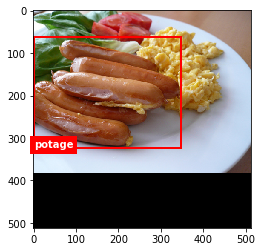

In [10]:
fig, axis= plt.subplots(1)

#randomly select image from dataset
i = np.random.randint(train_size)
img = train_raw[i][0].clone().numpy()

# unnormalize
img[0] = img[0] * 0.229
img[1] = img[1] * 0.224 
img[2] = img[2] * 0.225 
img[0] += 0.485 
img[1] += 0.456 
img[2] += 0.406
    
img = np.transpose(img, (1,2,0))
img = np.clip(img, 0, 1)
plt.imshow(img)

labels = train_raw[i][1]["labels"]
boxes = train_raw[i][1]["boxes"]

# draw bounding boxes
for i in range(len(labels)):
    x1, y1, x2, y2 = boxes[i]
    box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    axis.add_patch(box)
    axis.text(x1, y2, class_names[labels[i]-1], fontdict=dict(color='w', weight='bold'), bbox=dict(facecolor='r', edgecolor='none'))

fig

# Model

In order to train the food detector I will train from a pretrained Faster R-CNN model.

## Declare backbone model architecture

Currently supports:
    - resnet_50
    - mobilenet_v2

In [11]:
MODEL_NAME = "mobilenet_v2"

## Fetch pretrainied backbone and create RCNN

We can speed up convergence by using a backbone feature extractor trained on the Food101 dataset, except for the resnet-50 architecture which will be pretrained on coco.

In [13]:
print("Fetching pretrained model... ", end="")

if MODEL_NAME == "resnet_50":
    # fetch pretrained faster RCNN model with default resnet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # replace classification head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(class_names)+1)

    
elif MODEL_NAME == "mobilenet_v2":
    BACKBONE_PATH = os.path.join(ROOT_DIR, "models", "food_classification", MODEL_NAME, "fine_tuning.pt")
    
    # fetch backbone model architecture
    backbone = torchvision.models.mobilenet_v2(pretrained=False)
    
    # replace classification head
    num_features = backbone.classifier[1].in_features
    backbone.classifier[1] = torch.nn.Linear(num_features, 101)

    # load trained weights
    backbone.load_state_dict(torch.load(BACKBONE_PATH))

    # remove classification head
    backbone = backbone.features
    backbone.out_channels = 1280
    
    # encapsulate backbone within faster RCNN model
    anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.FasterRCNN(backbone, num_classes=len(class_names), rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)


model = model.to(device)
print("done")

Fetching pretrained model... done


## Load checkpoint if weights file exists

In [14]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_detection", MODEL_NAME, "fine_tuning.pt")

if os.path.exists(MODEL_PATH):
    print("Loading weights from checkpoint...", end="")
    model.load_state_dict(torch.load(MODEL_PATH))
    print("done")

# Train via fine-tuning

## Declare training parameters

In [15]:
learning_rate = 0.01
epochs = 5

# fetch trainable parameters for transfer learning(where requires_grad = true)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=learning_rate)

## Train and save model

In [16]:
for epoch in range(epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=1000)
    evaluate(model, val_loader, device)
    
    # overwrite model weights file
    torch.save(model.state_dict(), MODEL_PATH)

Epoch: [0]  [    0/26007]  eta: 11:40:51  lr: 0.000020  loss: 6.2970 (6.2970)  loss_classifier: 5.5254 (5.5254)  loss_box_reg: 0.0445 (0.0445)  loss_objectness: 0.7071 (0.7071)  loss_rpn_box_reg: 0.0200 (0.0200)  time: 1.6169  data: 0.0090  max mem: 1559
Epoch: [0]  [ 1000/26007]  eta: 1:16:02  lr: 0.010000  loss: 0.3612 (0.7826)  loss_classifier: 0.2202 (0.4925)  loss_box_reg: 0.0836 (0.0802)  loss_objectness: 0.0175 (0.1529)  loss_rpn_box_reg: 0.0443 (0.0570)  time: 0.1836  data: 0.0079  max mem: 1817
Epoch: [0]  [ 2000/26007]  eta: 1:14:04  lr: 0.010000  loss: 0.3102 (0.5678)  loss_classifier: 0.1848 (0.3486)  loss_box_reg: 0.0669 (0.0765)  loss_objectness: 0.0090 (0.0914)  loss_rpn_box_reg: 0.0214 (0.0513)  time: 0.1945  data: 0.0106  max mem: 1817
Epoch: [0]  [ 3000/26007]  eta: 1:12:27  lr: 0.010000  loss: 0.3432 (0.4988)  loss_classifier: 0.2188 (0.3065)  loss_box_reg: 0.0762 (0.0775)  loss_objectness: 0.0081 (0.0687)  loss_rpn_box_reg: 0.0227 (0.0461)  time: 0.1866  data: 0.009

Test:  [ 800/2890]  eta: 0:01:43  model_time: 0.0369 (0.0364)  evaluator_time: 0.0020 (0.0023)  time: 0.0492  data: 0.0087  max mem: 1817
Test:  [ 900/2890]  eta: 0:01:38  model_time: 0.0371 (0.0364)  evaluator_time: 0.0020 (0.0023)  time: 0.0499  data: 0.0095  max mem: 1817
Test:  [1000/2890]  eta: 0:01:33  model_time: 0.0349 (0.0364)  evaluator_time: 0.0020 (0.0022)  time: 0.0473  data: 0.0094  max mem: 1817
Test:  [1100/2890]  eta: 0:01:28  model_time: 0.0359 (0.0364)  evaluator_time: 0.0020 (0.0022)  time: 0.0484  data: 0.0099  max mem: 1817
Test:  [1200/2890]  eta: 0:01:23  model_time: 0.0360 (0.0364)  evaluator_time: 0.0020 (0.0022)  time: 0.0484  data: 0.0093  max mem: 1817
Test:  [1300/2890]  eta: 0:01:18  model_time: 0.0369 (0.0364)  evaluator_time: 0.0020 (0.0022)  time: 0.0501  data: 0.0099  max mem: 1817
Test:  [1400/2890]  eta: 0:01:13  model_time: 0.0381 (0.0364)  evaluator_time: 0.0020 (0.0022)  time: 0.0515  data: 0.0106  max mem: 1817
Test:  [1500/2890]  eta: 0:01:08  

Epoch: [1]  [16000/26007]  eta: 0:32:31  lr: 0.010000  loss: 0.2147 (0.2813)  loss_classifier: 0.1751 (0.2208)  loss_box_reg: 0.0119 (0.0255)  loss_objectness: 0.0043 (0.0126)  loss_rpn_box_reg: 0.0127 (0.0223)  time: 0.1813  data: 0.0230  max mem: 1817
Epoch: [1]  [17000/26007]  eta: 0:29:07  lr: 0.010000  loss: 0.2173 (0.2795)  loss_classifier: 0.1637 (0.2194)  loss_box_reg: 0.0169 (0.0253)  loss_objectness: 0.0049 (0.0125)  loss_rpn_box_reg: 0.0192 (0.0223)  time: 0.1753  data: 0.0176  max mem: 1817
Epoch: [1]  [18000/26007]  eta: 0:25:46  lr: 0.010000  loss: 0.2523 (0.2781)  loss_classifier: 0.1985 (0.2182)  loss_box_reg: 0.0124 (0.0252)  loss_objectness: 0.0082 (0.0125)  loss_rpn_box_reg: 0.0186 (0.0222)  time: 0.1835  data: 0.0241  max mem: 1817
Epoch: [1]  [19000/26007]  eta: 0:22:27  lr: 0.010000  loss: 0.2375 (0.2777)  loss_classifier: 0.1968 (0.2178)  loss_box_reg: 0.0176 (0.0252)  loss_objectness: 0.0047 (0.0125)  loss_rpn_box_reg: 0.0082 (0.0222)  time: 0.1790  data: 0.0205

Epoch: [2]  [    0/26007]  eta: 1:19:05  lr: 0.010000  loss: 0.3161 (0.3161)  loss_classifier: 0.2406 (0.2406)  loss_box_reg: 0.0470 (0.0470)  loss_objectness: 0.0099 (0.0099)  loss_rpn_box_reg: 0.0186 (0.0186)  time: 0.1825  data: 0.0109  max mem: 1817
Epoch: [2]  [ 1000/26007]  eta: 1:09:30  lr: 0.010000  loss: 0.1942 (0.2566)  loss_classifier: 0.1605 (0.2025)  loss_box_reg: 0.0107 (0.0238)  loss_objectness: 0.0015 (0.0102)  loss_rpn_box_reg: 0.0139 (0.0200)  time: 0.1691  data: 0.0085  max mem: 1817
Epoch: [2]  [ 2000/26007]  eta: 1:08:13  lr: 0.010000  loss: 0.2067 (0.2493)  loss_classifier: 0.1828 (0.1960)  loss_box_reg: 0.0096 (0.0230)  loss_objectness: 0.0023 (0.0102)  loss_rpn_box_reg: 0.0120 (0.0201)  time: 0.1842  data: 0.0087  max mem: 1817
Epoch: [2]  [ 3000/26007]  eta: 1:07:13  lr: 0.010000  loss: 0.2301 (0.2513)  loss_classifier: 0.1809 (0.1980)  loss_box_reg: 0.0128 (0.0232)  loss_objectness: 0.0014 (0.0099)  loss_rpn_box_reg: 0.0133 (0.0202)  time: 0.1883  data: 0.0075

Test:  [ 800/2890]  eta: 0:01:36  model_time: 0.0319 (0.0325)  evaluator_time: 0.0030 (0.0030)  time: 0.0468  data: 0.0092  max mem: 1817
Test:  [ 900/2890]  eta: 0:01:31  model_time: 0.0319 (0.0325)  evaluator_time: 0.0030 (0.0030)  time: 0.0461  data: 0.0090  max mem: 1817
Test:  [1000/2890]  eta: 0:01:26  model_time: 0.0319 (0.0324)  evaluator_time: 0.0030 (0.0030)  time: 0.0453  data: 0.0090  max mem: 1817
Test:  [1100/2890]  eta: 0:01:22  model_time: 0.0309 (0.0324)  evaluator_time: 0.0030 (0.0030)  time: 0.0448  data: 0.0095  max mem: 1817
Test:  [1200/2890]  eta: 0:01:17  model_time: 0.0319 (0.0324)  evaluator_time: 0.0030 (0.0031)  time: 0.0465  data: 0.0092  max mem: 1817
Test:  [1300/2890]  eta: 0:01:12  model_time: 0.0319 (0.0324)  evaluator_time: 0.0030 (0.0030)  time: 0.0452  data: 0.0092  max mem: 1817
Test:  [1400/2890]  eta: 0:01:08  model_time: 0.0319 (0.0324)  evaluator_time: 0.0030 (0.0030)  time: 0.0460  data: 0.0093  max mem: 1817
Test:  [1500/2890]  eta: 0:01:03  

Epoch: [3]  [16000/26007]  eta: 0:27:45  lr: 0.010000  loss: 0.2203 (0.2238)  loss_classifier: 0.1849 (0.1719)  loss_box_reg: 0.0199 (0.0229)  loss_objectness: 0.0030 (0.0100)  loss_rpn_box_reg: 0.0131 (0.0190)  time: 0.1659  data: 0.0063  max mem: 1817
Epoch: [3]  [17000/26007]  eta: 0:24:59  lr: 0.010000  loss: 0.2094 (0.2233)  loss_classifier: 0.1587 (0.1714)  loss_box_reg: 0.0227 (0.0228)  loss_objectness: 0.0024 (0.0100)  loss_rpn_box_reg: 0.0120 (0.0191)  time: 0.1666  data: 0.0066  max mem: 1817
Epoch: [3]  [18000/26007]  eta: 0:22:12  lr: 0.010000  loss: 0.1720 (0.2233)  loss_classifier: 0.1269 (0.1714)  loss_box_reg: 0.0151 (0.0229)  loss_objectness: 0.0032 (0.0100)  loss_rpn_box_reg: 0.0156 (0.0191)  time: 0.1658  data: 0.0074  max mem: 1817
Epoch: [3]  [19000/26007]  eta: 0:19:31  lr: 0.010000  loss: 0.1679 (0.2224)  loss_classifier: 0.1406 (0.1705)  loss_box_reg: 0.0120 (0.0228)  loss_objectness: 0.0016 (0.0100)  loss_rpn_box_reg: 0.0132 (0.0191)  time: 0.1930  data: 0.0075

Epoch: [4]  [    0/26007]  eta: 1:21:41  lr: 0.010000  loss: 0.4552 (0.4552)  loss_classifier: 0.2139 (0.2139)  loss_box_reg: 0.1479 (0.1479)  loss_objectness: 0.0175 (0.0175)  loss_rpn_box_reg: 0.0759 (0.0759)  time: 0.1885  data: 0.0089  max mem: 1817
Epoch: [4]  [ 1000/26007]  eta: 1:09:27  lr: 0.010000  loss: 0.1672 (0.2011)  loss_classifier: 0.1170 (0.1532)  loss_box_reg: 0.0130 (0.0212)  loss_objectness: 0.0013 (0.0072)  loss_rpn_box_reg: 0.0121 (0.0195)  time: 0.1652  data: 0.0062  max mem: 1817
Epoch: [4]  [ 2000/26007]  eta: 1:06:46  lr: 0.010000  loss: 0.1559 (0.1988)  loss_classifier: 0.1140 (0.1527)  loss_box_reg: 0.0104 (0.0207)  loss_objectness: 0.0015 (0.0067)  loss_rpn_box_reg: 0.0152 (0.0187)  time: 0.1671  data: 0.0065  max mem: 1817
Epoch: [4]  [ 3000/26007]  eta: 1:03:59  lr: 0.010000  loss: 0.1488 (0.2005)  loss_classifier: 0.1250 (0.1534)  loss_box_reg: 0.0104 (0.0211)  loss_objectness: 0.0011 (0.0076)  loss_rpn_box_reg: 0.0079 (0.0185)  time: 0.1670  data: 0.0066

Test:  [ 800/2890]  eta: 0:01:40  model_time: 0.0329 (0.0339)  evaluator_time: 0.0030 (0.0035)  time: 0.0473  data: 0.0097  max mem: 1817
Test:  [ 900/2890]  eta: 0:01:35  model_time: 0.0339 (0.0339)  evaluator_time: 0.0030 (0.0035)  time: 0.0480  data: 0.0093  max mem: 1817
Test:  [1000/2890]  eta: 0:01:30  model_time: 0.0329 (0.0339)  evaluator_time: 0.0030 (0.0035)  time: 0.0472  data: 0.0095  max mem: 1817
Test:  [1100/2890]  eta: 0:01:26  model_time: 0.0339 (0.0339)  evaluator_time: 0.0040 (0.0035)  time: 0.0493  data: 0.0094  max mem: 1817
Test:  [1200/2890]  eta: 0:01:21  model_time: 0.0349 (0.0340)  evaluator_time: 0.0030 (0.0036)  time: 0.0502  data: 0.0099  max mem: 1817
Test:  [1300/2890]  eta: 0:01:16  model_time: 0.0349 (0.0341)  evaluator_time: 0.0030 (0.0036)  time: 0.0483  data: 0.0088  max mem: 1817
Test:  [1400/2890]  eta: 0:01:11  model_time: 0.0349 (0.0342)  evaluator_time: 0.0040 (0.0036)  time: 0.0496  data: 0.0093  max mem: 1817
Test:  [1500/2890]  eta: 0:01:07  